# Data analysis and pre processing
This notebook explores the input data to perform feature engineering.

#### Libraries and options

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [3]:
def list_directory_tree_with_os_walk(starting_directory):
    for root, directories, files in os.walk(starting_directory):
        print(f"Directory: {root}")
        for file in files:
            print(f"  File: {file}")
# Check the directory
base_directory = 'C:/Users/NOE/source/repos/Energy-forecasting-NTNU/data/'
os.chdir(base_directory)
list_directory_tree_with_os_walk('.')

Directory: .
  File: .DS_Store
  File: Readme.md
  File: read_files.ipynb
  File: sample_submission.csv
  File: test.csv
Directory: .\.ipynb_checkpoints
  File: Data_exploration-checkpoint.ipynb
  File: Readme-checkpoint.md
  File: read_files-checkpoint.ipynb
Directory: .\A
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\B
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\C
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\Hugo
  File: read_files.ipynb
Directory: .\Noe
  File: Data_exploration.ipynb
  File: read_files.ipynb


## Data exploration

### Plot all the features
This only plots all the features for a given location. It can be pretty slow but helps to visualize the possible issues and pre-processing.

In [12]:
location = 'A'

train_target = pd.read_parquet(location+'/train_targets.parquet')
X_train_estimated = pd.read_parquet(location+'/X_train_estimated.parquet')
X_train_observed = pd.read_parquet(location+'/X_train_observed.parquet')
X_test_estimated = pd.read_parquet(location+'/X_test_estimated.parquet')

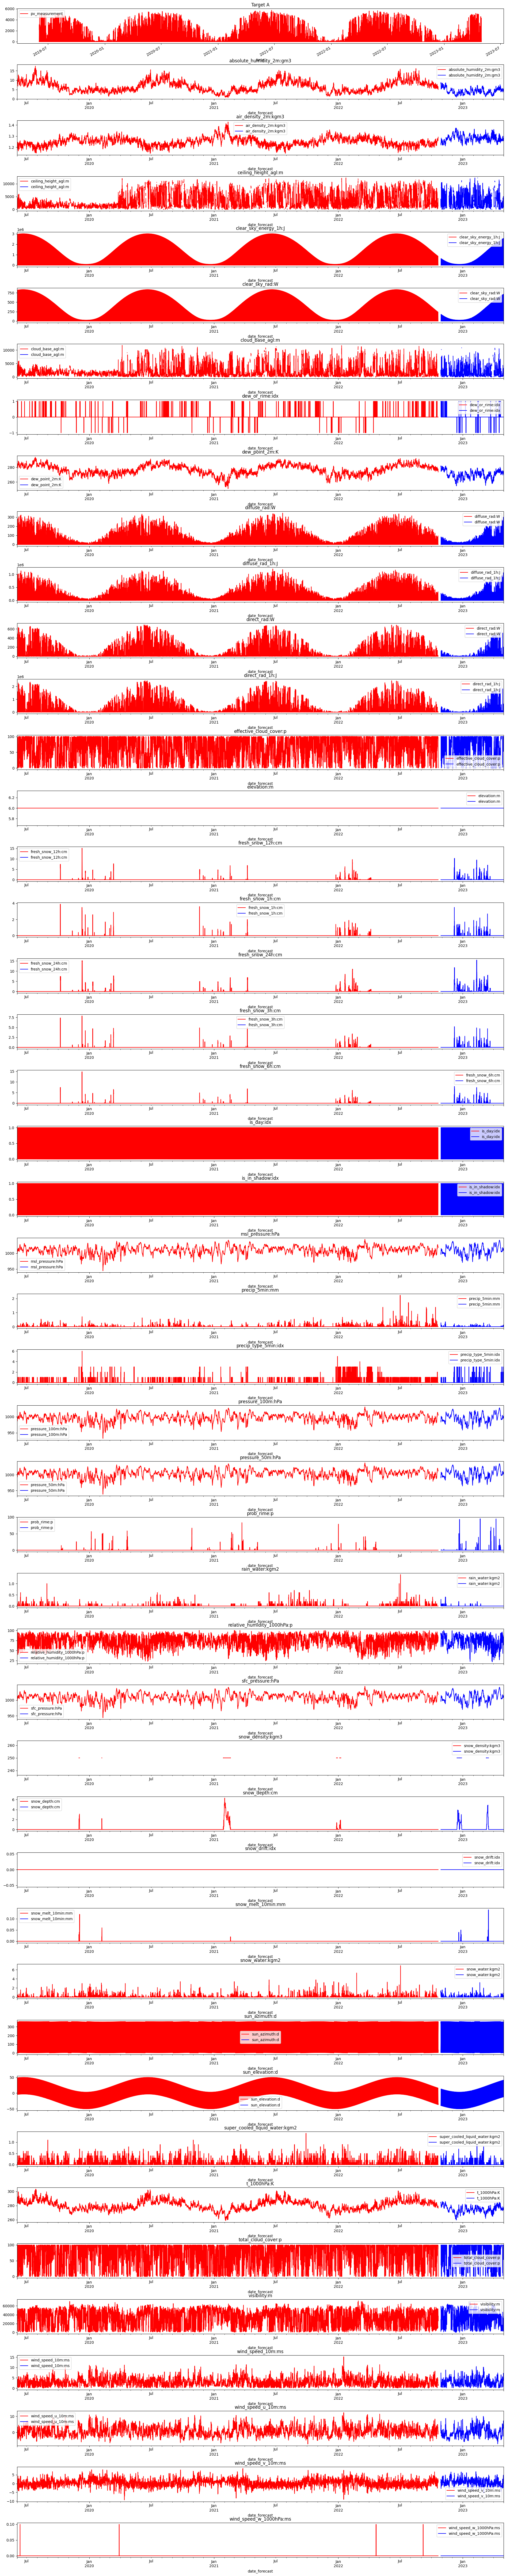

In [13]:
features = X_train_observed.keys()[1:] 

# Plotting train target and all training features
fig, axs = plt.subplots(len(features)+1, 1, figsize=(20, 120), sharex=False)
fig.tight_layout(pad=5.0)
# Plot target
train_target[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target '+str(location), color='red')

for k,feature_name in enumerate(features):
    X_train_observed[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[k+1], title=feature_name, color='red')
    X_train_estimated[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[k+1], title=feature_name, color='blue')
plt.show()

### Correlation between features
To get a better understanding at the correlation between all features we will show the correlation matrix. We will then remove the features that have high correlation coefficient as they would only make the model more complex without providing extra information:
- __correlation coefficient = 1__ : the two features are exactly the same (to a scale factor). This can be seen for all the pressure features. Only one feature should be kept
- __correlation coefficient > 0.9__ : the features are highly correlated, and contain almost identical values. This can be seen for `dew_point` and `absolute_humidity` for example. Keeping only one of the two should be enough for the model.
- __correlation coefficient < 0__ : the two features evolve in oposite directions (one goes down when the other increases). It can be seen for the features `is_in_shadow` and `sun_elevation` for example.
- __correlation coefficient = `NaN`__ : calculation failed, there is probably missing data.

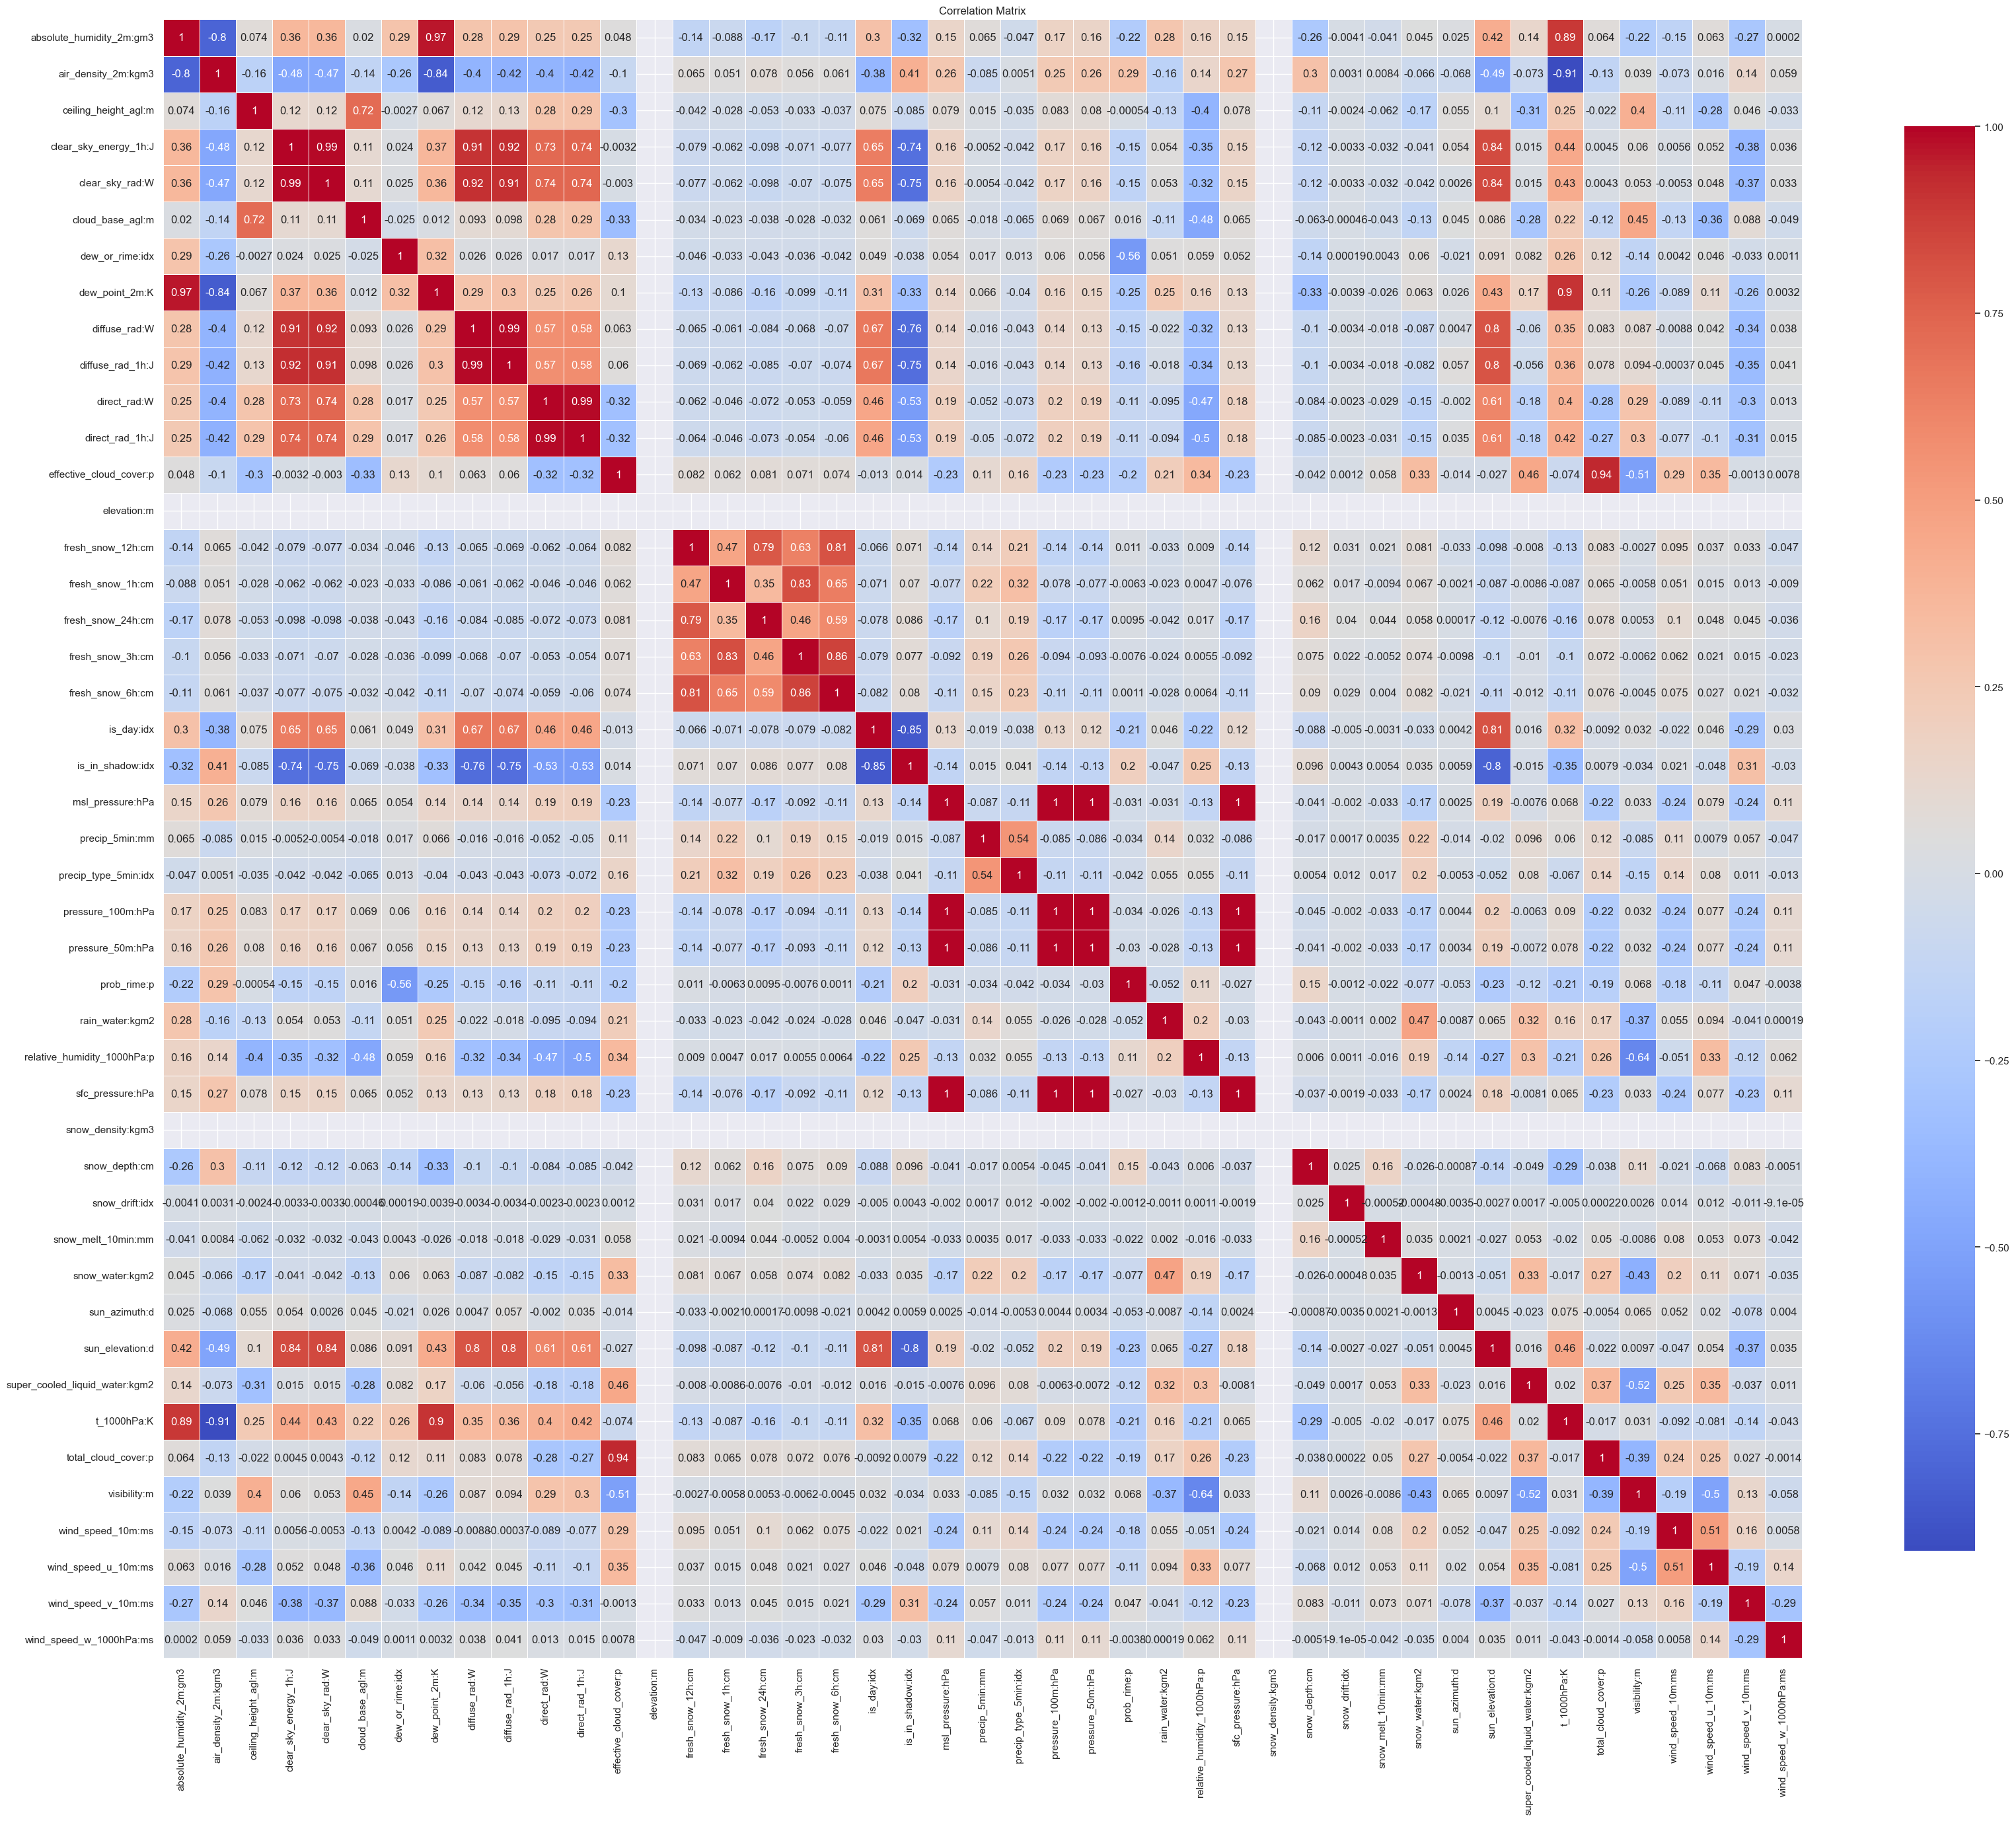

In [65]:
location = 'C'

X_train_estimated = pd.read_parquet(location+'/X_train_estimated.parquet')
X_train_observed = pd.read_parquet(location+'/X_train_observed.parquet')
X_test_estimated = pd.read_parquet(location+'/X_test_estimated.parquet')


# The data to plot
df = X_train_observed   

# Exclude the first column (date forecast, it's the time axis)
columns_to_include = df.columns[1:]

# Calculate the correlation matrix for selected columns
correlation_matrix = df[columns_to_include].corr()

# Set up the Seaborn heatmap
plt.figure(figsize=(40, 40))
sns.set(font_scale=1)      # Adjust the font scale

# Set up the Seaborn heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    linewidths=.5,
    square=True,
    cbar_kws={"shrink": 0.7},
    xticklabels=columns_to_include,
    yticklabels=columns_to_include
)

plt.title("Correlation Matrix")
plt.show()

We will now focus on removing the highly correlated features. For that, we use the following function :

In [71]:
def find_low_correlation_columns(correlation_matrix, threshold):
        
    feature_list = list(correlation_matrix.columns)
    removed_list = []
    for reference_index in range(len(feature_list)):
        reference_feature = feature_list[reference_index]

        # Check if this feature has not already been removed
        if reference_feature not in removed_list:
            for compared_index in range(reference_index+1,len(feature_list)):
                compared_feature = feature_list[compared_index]

                # Check if this feature has not already been removed
                if compared_feature not in removed_list:

                    # Get correlation coefficient
                    coefficient = correlation_matrix.loc[reference_feature,compared_feature]

                    # Remove column if it's a NaN
                    if pd.isna(coefficient):
                        removed_list.append(compared_feature)
                        print(f"Removed {compared_feature} because it is NaN")
                        
                    # Remove if it is above threshold
                    if np.abs(coefficient)>=threshold:
                        removed_list.append(compared_feature)
                        print(f"Removed {compared_feature} because it is correlated to {reference_feature}")
    
    
    output_list = feature_list.copy()
    for element in removed_list:
        output_list.remove(element)
        
    return list(output_list)

Removed dew_point_2m:K because it is correlated to absolute_humidity_2m:gm3
Removed elevation:m because it is NaN
Removed snow_density:kgm3 because it is NaN
Removed t_1000hPa:K because it is correlated to air_density_2m:kgm3
Removed clear_sky_rad:W because it is correlated to clear_sky_energy_1h:J
Removed diffuse_rad:W because it is correlated to clear_sky_energy_1h:J
Removed diffuse_rad_1h:J because it is correlated to clear_sky_energy_1h:J
Removed direct_rad_1h:J because it is correlated to direct_rad:W
Removed total_cloud_cover:p because it is correlated to effective_cloud_cover:p
Removed pressure_100m:hPa because it is correlated to msl_pressure:hPa
Removed pressure_50m:hPa because it is correlated to msl_pressure:hPa
Removed sfc_pressure:hPa because it is correlated to msl_pressure:hPa
33 features remaining


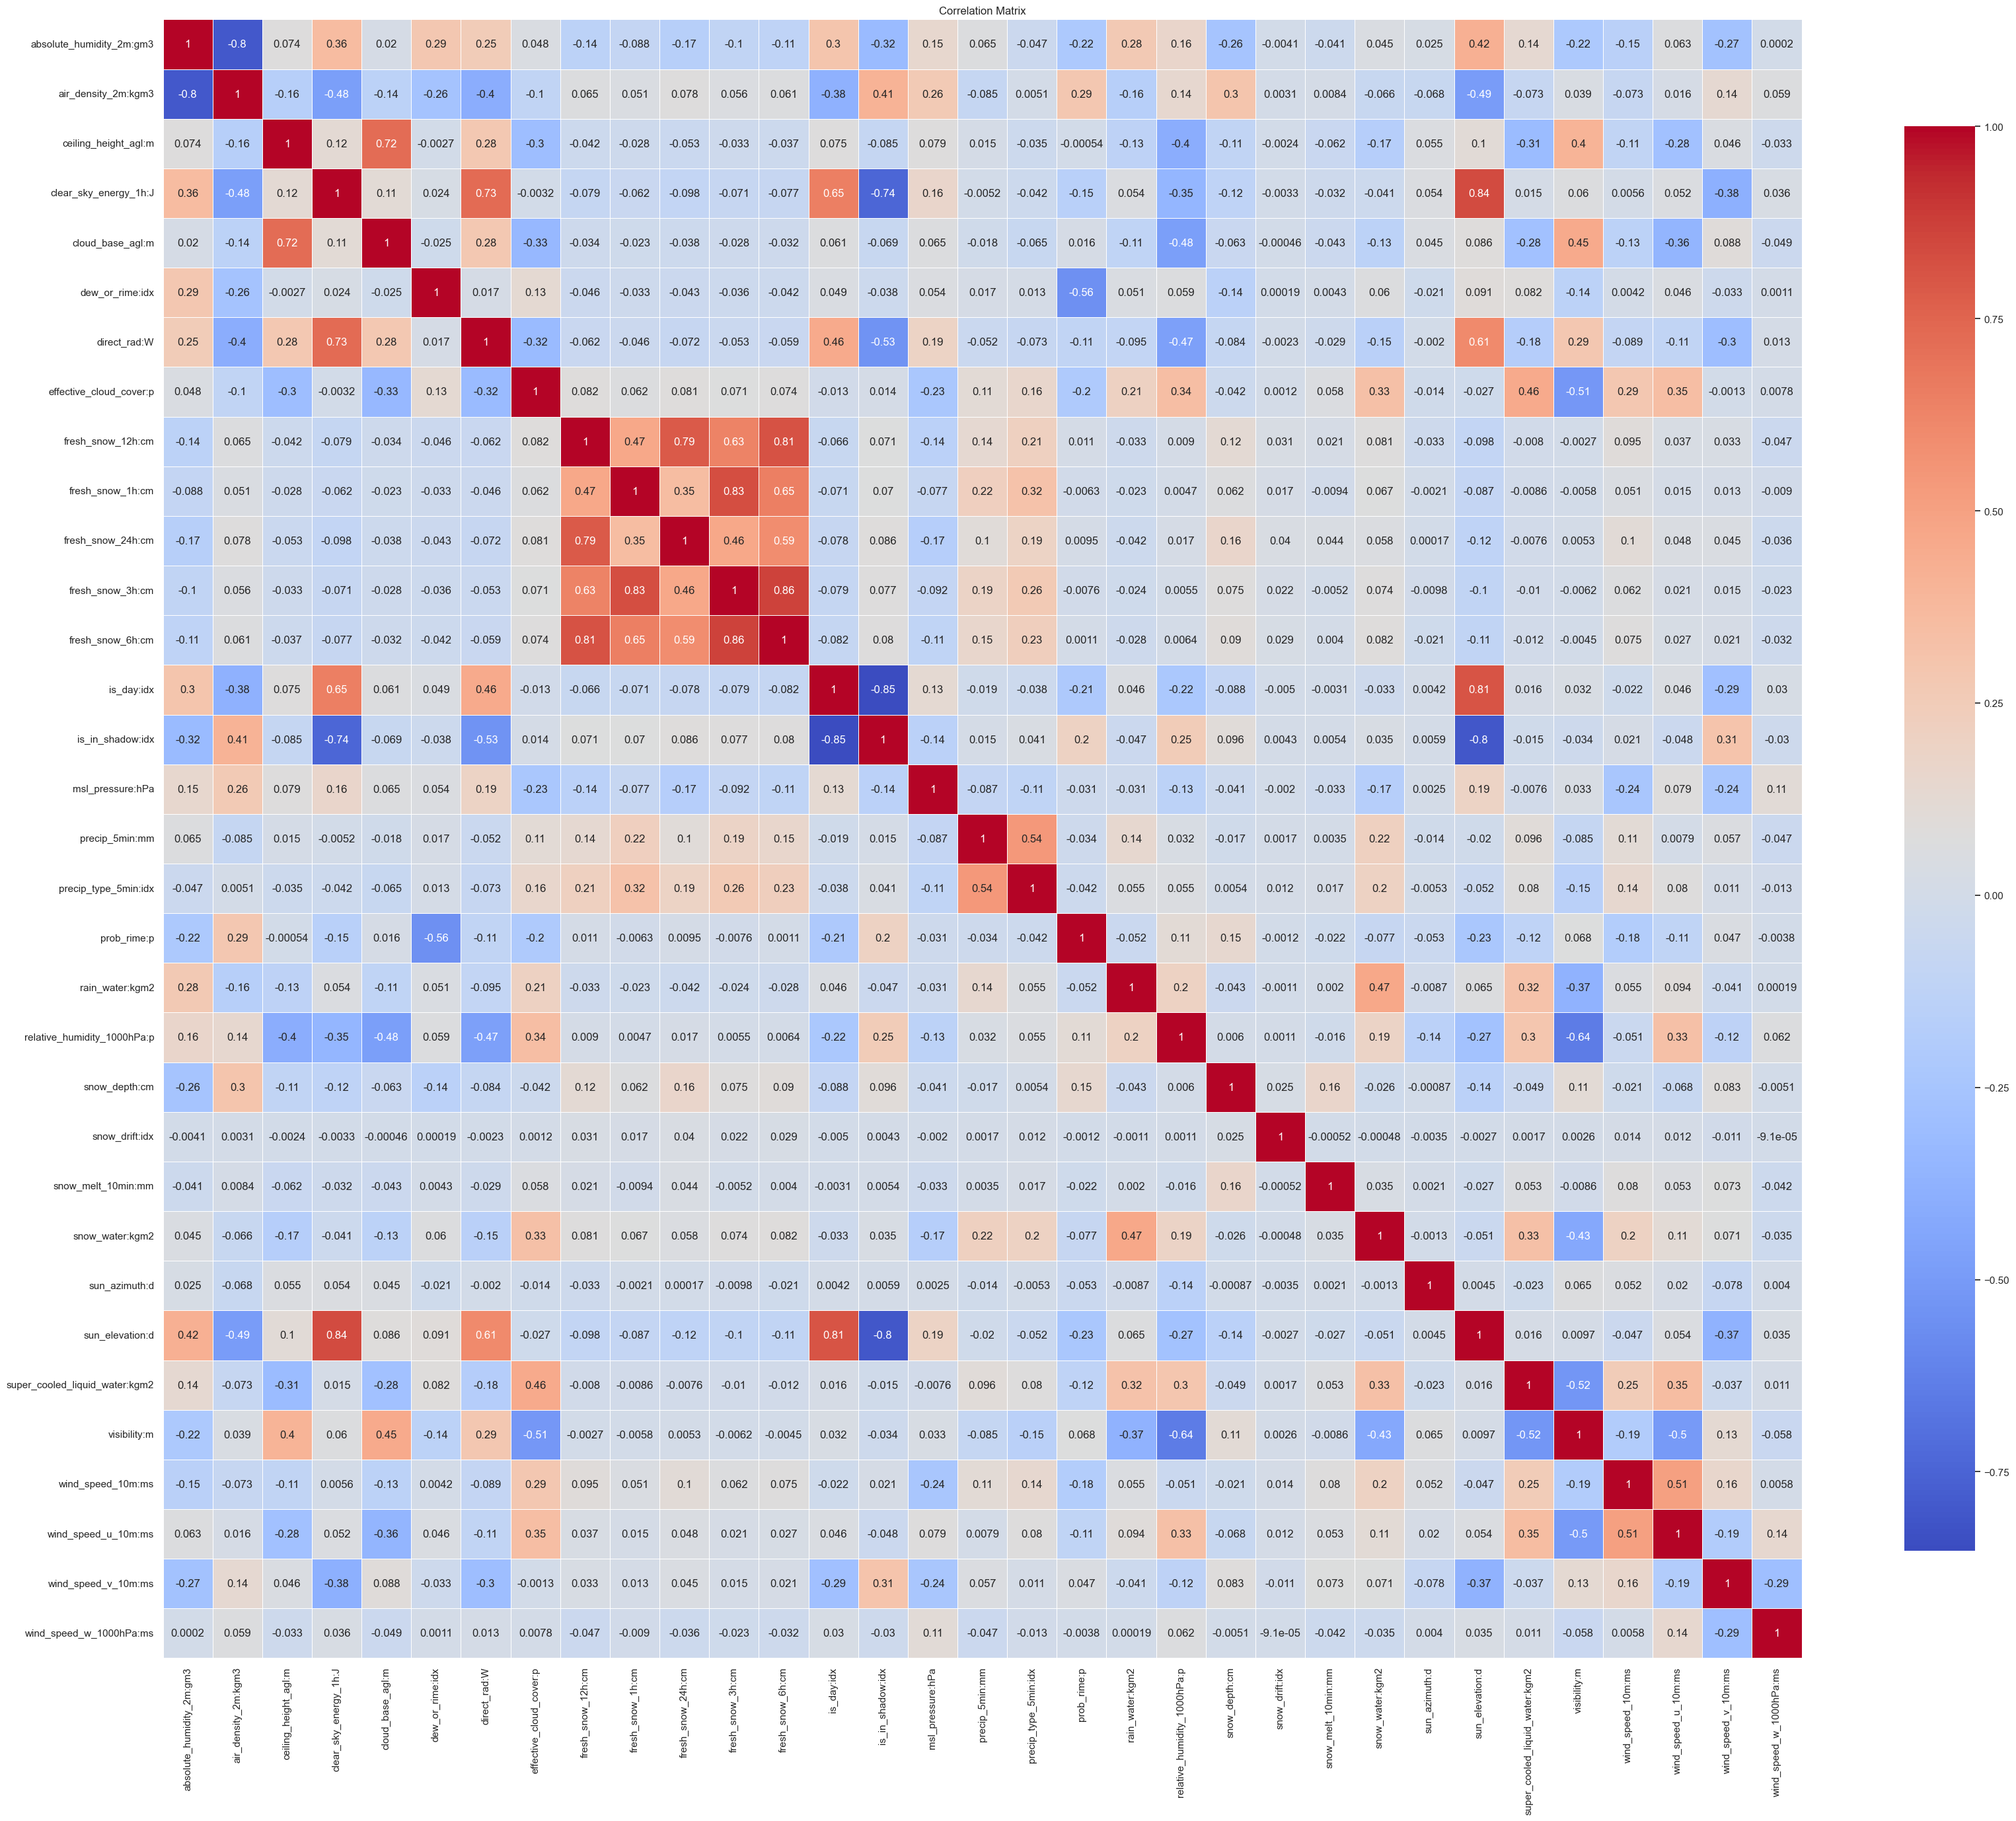

In [72]:
features = find_low_correlation_columns(correlation_matrix,threshold=0.9)
print(f"{len(features)} features remaining")


# We now compute another correlation matrix to make sure that we excluded the correct features
# Select the non correlated features
columns_to_include = features

# Calculate the correlation matrix for selected columns
correlation_matrix_filtered = df[columns_to_include].corr()

# Set up the Seaborn heatmap
plt.figure(figsize=(40, 40))
sns.set(font_scale=1)      # Adjust the font scale

# Set up the Seaborn heatmap
sns.heatmap(
    correlation_matrix_filtered,
    annot=True,
    cmap='coolwarm',
    linewidths=.5,
    square=True,
    cbar_kws={"shrink": 0.7},
    xticklabels=columns_to_include,
    yticklabels=columns_to_include
)

plt.title("Correlation Matrix")
plt.show()

